In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from moist_thermodynamics import functions as mt
from moist_thermodynamics import constants
from moist_thermodynamics import saturation_vapor_pressures as svp

i4T = np.vectorize(mt.invert_for_temperature)

In [2]:
svp.make_analytic?

Signature: svp.make_analytic(lx, cx)
Docstring:
closure function for analytic saturation vapor pressure

Sets up the rankine (constant specific heat, negligible condensate volume) approximations to
calculate the saturation vapor pressure over a phase with the specific heat cx, and phase
change enthalpy (from vapor) lx, at temperature T.

Args:
    lx: phase change enthalpy between vapor and given phase (liquid, ice)
    cx: specific heat capacity of given phase (liquid, ice)

Returns:
    a function for the saturation vaporp pressure consistent with choice of lx and cx

Reference:
    Romps, D. M. Exact Expression for the Lifting Condensation Level. Journal of the Atmospheric
    Sciences 74, 3891–3900 (2017).
    Romps, D. M. Accurate expressions for the dew point and frost point derived from the Rankine-
    Kirchhoff approximations. Journal of the Atmospheric Sciences (2021) doi:10.1175/JAS-D-20-0301.1.
    
>>> es = make_analytic(constants.lvT,constants.cl)
>>> es( np.asarray([273.

# Examples

Usage of the moist thermodynamic functions is documented through a number of examples

1. saturation vapor pressure
2. constructing a moist adiabat.
3. sensitivity of moist adiabat to saturation vapor pressure 
4. lcl computations
5. Integrating the first law to arrive at the moist adiabat

## 1. saturation vapor pressure 

We compare the error of the much simpler Teten's formulae to those of the reference formulae for the three cases of liquid, super-cooled liquid and ice.  The reference fits for these are respectively Wagner and Pruss, Koop and Murray, and Wagner et al.  For liquid the fits are quite good, to within better than 0.15%.  For ice and super-cooled water they simple formulae are less accurate, with errors of a few percent at 230 K and larger for colder temperatures.

In the second plot we compare the extrapolation of the Wanger and Pruss formula, which was derived for temperatures between the triple and critical points, for saturation with respect to super cooled liquid using Murphy and Koop as the super-cooled reference.   Murphy and Koop is fit for temperatures (123K-332K) spanning conditions of earth's atmosphere. The comparison is for extreme temperatures.  Generally extrapolating Wagner and Pruss for super cooled water is a better fit from the Murray specification of the Teten's formual.

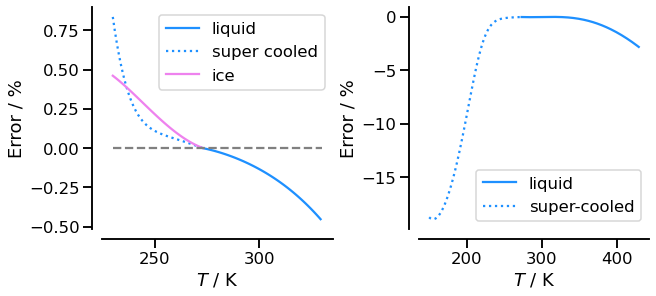

In [3]:
Tw = np.arange(273.15, 330.0)
es = svp.liq_analytic(Tw)
es_def = svp.liq_wagner_pruss(Tw)
err1 = (es / es_def - 1.0) * 100.0

Tc = np.arange(230.0, 273.15)
es = svp.liq_analytic(Tc)
es_def = svp.liq_murphy_koop(Tc)
err2 = (es / es_def - 1.0) * 100.0

es = svp.ice_analytic(Tc)
es_def = svp.ice_wagner_etal(Tc)
err3 = (es / es_def - 1.0) * 100.0

sns.set_context("talk")
fig, ax = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)

ax[0].plot(Tw, err1, label="liquid", c="dodgerblue")
ax[0].plot(Tc, err2, label="super cooled", ls="dotted", c="dodgerblue")
ax[0].plot(Tc, err3, label="ice", c="violet")

Tw = np.arange(273.16, 430)
es = svp.liq_wagner_pruss(Tw)
es_def = svp.liq_murphy_koop(Tw)
err1 = (es / es_def - 1.0) * 100.0
ax[1].plot(Tw, err1, label="liquid", c="dodgerblue")
Tw = np.arange(150, 273.16)
es_def = svp.liq_wagner_pruss(Tw)
es = svp.liq_murphy_koop(Tw)
err1 = (es / es_def - 1.0) * 100.0
ax[1].plot(Tw, err1, label="super-cooled", c="dodgerblue", ls="dotted")

ax[0].hlines(0, 230, 330.0, ls="dashed", color="grey")
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel("$T$ / K")
ax[0].set_xlabel("$T$ / K")
ax[0].set_ylabel("Error / %")
ax[1].set_ylabel("Error / %")

sns.despine(offset=10)

## 2. Constructing a moist adiabat

This shows how simple it is to construct a moist adiabat.  For the example it is constructed by assuming a constant $\theta_\mathrm{l}$ but the same answer (with the caveats of the next example) would arise if we were to define it in terms of constant $\theta_\mathrm{e}$ or $\theta_\mathrm{s}$

0.016751645341371288


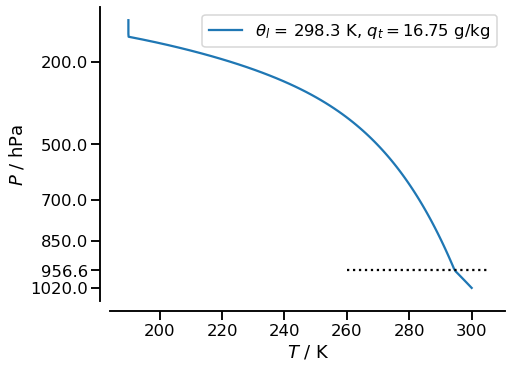

In [4]:
es = svp.liq_analytic
p2q = mt.partial_pressure_to_specific_humidity
theta_l = mt.theta_l
i4T = np.vectorize(mt.invert_for_temperature)

Psfc = 102000.0
Tsfc = 300.0
Tmin = 190.0
dP = 1000.0
P = np.arange(Psfc, 0.4e4, -dP)

RH = 0.77
qt = p2q(RH * es(Tsfc), Psfc)
print(qt)

sns.set_context("talk")
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)

Tl = theta_l(Tsfc, Psfc, qt)
TK = np.maximum(i4T(mt.theta_l, Tl, P, qt), Tmin)
ax.plot(TK, P / 100.0, label=f"$\\theta_l$ = {Tl:.1f} K, $q_t = ${1000*qt:.2f} g/kg")

Plcl = mt.plcl(Tsfc, Psfc, qt).squeeze() / 100.0

ax.hlines(Plcl, 260, 305.0, ls="dotted", color="k")
ax.set_yticks([Psfc / 100, Plcl, 850.0, 700, 500, 200])
plt.gca().invert_yaxis()
plt.legend()

ax.set_xlabel("$T$ / K")
ax.set_ylabel("$P$ / hPa")
# plt.grid()
sns.despine(offset=10)

## 3. Sensitivity (small) of moist adiabat on saturation vapor pressure 

The derivation of the moist potential temperatures assumes a Rankine fluid, i.e., constant specific heats. Specific heats vary with temperature however, especially $c_i$.  This variation is encoded in the best fits to the saturation vapor pressure, so that an adiabat defined in terms of a best fit saturation vapor pressure will differ depending on whether it assumes $\theta_\mathrm{e},$ $\theta_\mathrm{l},$ or $\theta_\mathrm{s}.$  This sensitivity vanishes (right plot, note $x$-axis scale) when we replace the more accurate saturation vapor pressures with less accurate expressions, albeit consistent with a Rankine fluid.

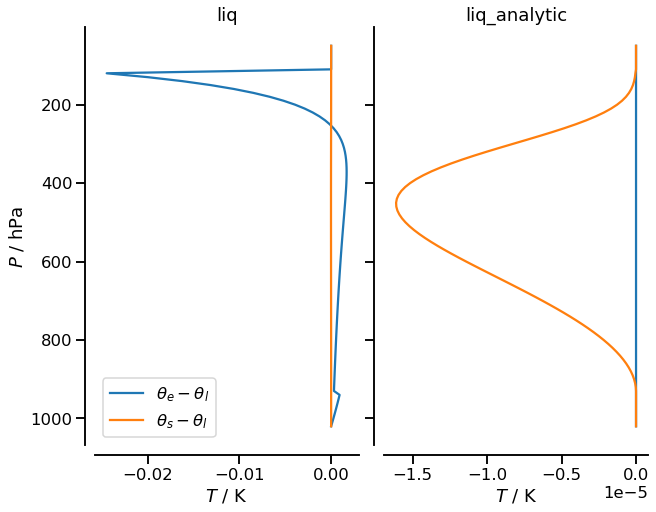

In [5]:
theta_e, theta_l, theta_s = mt.theta_e, mt.theta_l, mt.theta_s

Tmin = 190.0
dP = 1000.0
P = np.arange(Psfc, 0.4e4, -dP)

Psfc = 102000.0
Tsfc = 300.0
qt = 15.0e-3

sns.set_context("talk")
fig, ax = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True, sharey=True)

es = svp.liq_analytic
TKl = np.maximum(i4T(theta_l, theta_l(Tsfc, Psfc, qt, es=es), P, qt, es=es), Tmin)
TKe = np.maximum(i4T(theta_e, theta_e(Tsfc, Psfc, qt, es=es), P, qt, es=es), Tmin)
TKs = np.maximum(i4T(theta_s, theta_s(Tsfc, Psfc, qt, es=es), P, qt, es=es), Tmin)
ax[1].plot(TKe - TKl, P / 100.0, label="$\\theta_e-\\theta_l$")
ax[1].plot(TKs - TKl, P / 100.0, label="$\\theta_s-\\theta_l$")
ax[1].set_title("liq_analytic")

es = svp.liq_wagner_pruss
TKl = np.maximum(i4T(theta_l, theta_l(Tsfc, Psfc, qt, es=es), P, qt, es=es), Tmin)
TKe = np.maximum(i4T(theta_e, theta_e(Tsfc, Psfc, qt, es=es), P, qt, es=es), Tmin)
TKs = np.maximum(i4T(theta_s, theta_s(Tsfc, Psfc, qt, es=es), P, qt, es=es), Tmin)
ax[0].plot(TKe - TKl, P / 100.0, label="$\\theta_e-\\theta_l$")
ax[0].plot(TKs - TKl, P / 100.0, label="$\\theta_s-\\theta_l$")
ax[0].set_title("liq")

plt.gca().invert_yaxis()

ax[0].set_xlabel("$T$ / K")
ax[1].set_xlabel("$T$ / K")

ax[0].set_ylabel("$P$ / hPa")
ax[0].legend()

sns.despine(offset=10)

## 4. Calculations of lifting condensation level

We compare three different formulations of the lifting condensation level, one due to Romps (2017) is not included in the moist_thermodynamics library, but is included here for sake of comparision.  The analysis shows that the simple bolton approximations work very well, as well as those of Romps if one uses the wagner saturation vapor pressure data.  Had we performed this comparison with the analytic formula using the specific heats specified by Romps, the comparison would have been more favorable for the Romps formulation.

In [6]:
# Version 1.0 released by David Romps on September 12, 2017.
#
# When using this code, please cite:
#
# @article{16lcl,
#   Title   = {Exact expression for the lifting condensation level},
#   Author  = {David M. Romps},
#   Journal = {Journal of the Atmospheric Sciences},
#   Year    = {2017},
#   Volume  = {in press},
# }
#
# This lcl function returns the height of the lifting condensation level
# (LCL) in meters.  The inputs are:
# - p in Pascals
# - T in Kelvins
# - Exactly one of rh, rhl, and rhs (dimensionless, from 0 to 1):
#    * The value of rh is interpreted to be the relative humidity with
#      respect to liquid water if T >= 273.15 K and with respect to ice if
#      T < 273.15 K.
#    * The value of rhl is interpreted to be the relative humidity with
#      respect to liquid water
#    * The value of rhs is interpreted to be the relative humidity with
#      respect to ice
# - ldl is an optional logical flag.  If true, the lifting deposition
#   level (LDL) is returned instead of the LCL.
# - min_lcl_ldl is an optional logical flag.  If true, the minimum of the
#   LCL and LDL is returned.


def lcl(p, T, rh=None, rhl=None, rhs=None, return_ldl=False, return_min_lcl_ldl=False):
    import math
    import scipy.special

    # Parameters
    Ttrip = 273.16  # K
    ptrip = 611.65  # Pa
    E0v = 2.3740e6  # J/kg
    E0s = 0.3337e6  # J/kg
    ggr = 9.81  # m/s^2
    rgasa = 287.04  # J/kg/K
    rgasv = 461  # J/kg/K
    cva = 719  # J/kg/K
    cvv = 1418  # J/kg/K
    cvl = 4119  # J/kg/K
    cvs = 1861  # J/kg/K
    cpa = cva + rgasa
    cpv = cvv + rgasv

    # The saturation vapor pressure over liquid water
    def pvstarl(T):
        return (
            ptrip
            * (T / Ttrip) ** ((cpv - cvl) / rgasv)
            * math.exp((E0v - (cvv - cvl) * Ttrip) / rgasv * (1 / Ttrip - 1 / T))
        )

    # The saturation vapor pressure over solid ice
    def pvstars(T):
        return (
            ptrip
            * (T / Ttrip) ** ((cpv - cvs) / rgasv)
            * math.exp((E0v + E0s - (cvv - cvs) * Ttrip) / rgasv * (1 / Ttrip - 1 / T))
        )

    # Calculate pv from rh, rhl, or rhs
    rh_counter = 0
    if rh is not None:
        rh_counter = rh_counter + 1
    if rhl is not None:
        rh_counter = rh_counter + 1
    if rhs is not None:
        rh_counter = rh_counter + 1
    if rh_counter != 1:
        print(rh_counter)
        exit("Error in lcl: Exactly one of rh, rhl, and rhs must be specified")
    if rh is not None:
        # The variable rh is assumed to be
        # with respect to liquid if T > Ttrip and
        # with respect to solid if T < Ttrip
        if T > Ttrip:
            pv = rh * pvstarl(T)
        else:
            pv = rh * pvstars(T)
            rhl = pv / pvstarl(T)
            rhs = pv / pvstars(T)
    elif rhl is not None:
        pv = rhl * pvstarl(T)
        rhs = pv / pvstars(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    elif rhs is not None:
        pv = rhs * pvstars(T)
        rhl = pv / pvstarl(T)
        if T > Ttrip:
            rh = rhl
        else:
            rh = rhs
    if pv > p:
        return None

    # Calculate lcl_liquid and lcl_solid
    qv = rgasa * pv / (rgasv * p + (rgasa - rgasv) * pv)
    rgasm = (1 - qv) * rgasa + qv * rgasv
    cpm = (1 - qv) * cpa + qv * cpv
    if rh == 0:
        return cpm * T / ggr
    aL = -(cpv - cvl) / rgasv + cpm / rgasm
    bL = -(E0v - (cvv - cvl) * Ttrip) / (rgasv * T)
    cL = pv / pvstarl(T) * math.exp(-(E0v - (cvv - cvl) * Ttrip) / (rgasv * T))
    aS = -(cpv - cvs) / rgasv + cpm / rgasm
    bS = -(E0v + E0s - (cvv - cvs) * Ttrip) / (rgasv * T)
    cS = pv / pvstars(T) * math.exp(-(E0v + E0s - (cvv - cvs) * Ttrip) / (rgasv * T))
    X = bL / (aL * scipy.special.lambertw(bL / aL * cL ** (1 / aL), -1).real)
    Y = bS / (aS * scipy.special.lambertw(bS / aS * cS ** (1 / aS), -1).real)

    # lcl = cpm * T / ggr * (1 - X)
    # ldl = cpm * T / ggr * (1 - Y)

    # Modifications of the code to output Plcl or Pldl
    Plcl = PPa * X ** (cpm / rgasm)
    Pldl = PPa * Y ** (cpm / rgasm)
    # Return either lcl or ldl
    if return_ldl and return_min_lcl_ldl:
        exit("return_ldl and return_min_lcl_ldl cannot both be true")
    elif return_ldl:
        return Pldl
    elif return_min_lcl_ldl:
        return min(Plcl, Pldl)
    else:
        return Plcl

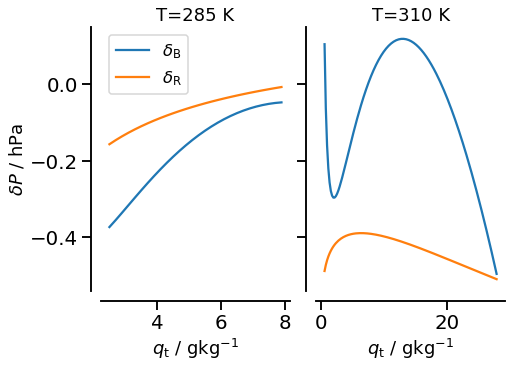

In [7]:
PPa = 101325.0
qt = np.arange(2.5e-3, 8.0e-3, 0.2e-3)
TK = 285.0
Plcl_X = np.zeros(len(qt))
Plcl_B = np.zeros(len(qt))
Plcl_R = np.zeros(len(qt))

for i, x in enumerate(qt):
    RH = mt.mixing_ratio_to_partial_pressure(x / (1.0 - x), PPa) / svp.liq_analytic(TK)
    Plcl_R[i] = lcl(PPa, TK, RH)
    Plcl_X[i] = mt.plcl(TK, PPa, x)
    Plcl_B[i] = mt.plcl_bolton(TK, PPa, x)

del1 = (Plcl_B - Plcl_X) / 100.0
del2 = (Plcl_R - Plcl_X) / 100.0

fig, axs = plt.subplots(1, 2, figsize=(7, 5), constrained_layout=True, sharey=True)

axs[0].plot(qt * 1.0e3, del1, label="$\\delta_\mathrm{B}$")
axs[0].plot(qt * 1.0e3, del2, label="$\\delta_\mathrm{R}$")
axs[0].legend(loc="best")
axs[0].set_ylabel("$\delta P$ / hPa")
axs[0].set_xlabel("$q_\mathrm{t}$ / gkg$^{-1}$")
axs[0].set_title(f"T={TK:.0f} K")

qt = np.arange(0.5e-3, 28.0e-3, 0.2e-3)
TK = 310.0

Plcl_X = np.zeros(len(qt))
Plcl_B = np.zeros(len(qt))
Plcl_R = np.zeros(len(qt))
for i, x in enumerate(qt):
    RH = mt.mixing_ratio_to_partial_pressure(x / (1.0 - x), PPa) / svp.liq_wagner_pruss(
        TK
    )
    Plcl_R[i] = lcl(PPa, TK, RH)
    Plcl_X[i] = mt.plcl(TK, PPa, x)
    Plcl_B[i] = mt.plcl_bolton(TK, PPa, x)

del1 = (Plcl_B - Plcl_X) / 100.0
del2 = (Plcl_R - Plcl_X) / 100.0

axs[1].plot(qt * 1.0e3, del1)
axs[1].plot(qt * 1.0e3, del2)
axs[1].set_xlabel("$q_\mathrm{t}$ / gkg$^{-1}$")
axs[1].set_title(f"T={TK:.0f} K")

sns.set_context("talk", font_scale=1.2)
sns.despine(offset=10)
# fig.savefig(plot_dir+'Plcl.pdf')

## 5. Integrating the first law to arrive at the moist adiabat

This example shows how to construct a moist adiabat allowing for equilibrium freezing.  To do so it makes use of two calls of the moist_adiabat function.  The first calculates the moist adiabat assuming condensation only produces ice, the other only liquid, with the latter being valid for temperatures above T0, the former for temperatures below T0, and an isothermal T0 layer residing in between.  The result is plotted in terms of the dry potential temperature to better highlight the enhanced stability.

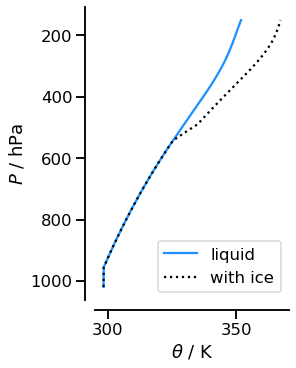

In [8]:
es = mt.make_es_mxd(es_liq=svp.liq_analytic, es_ice=svp.ice_analytic)
qt = 16.774409538883497e-3
Tice, Py = mt.moist_adiabat(
    Tsfc,
    Psfc,
    150e2,
    -10.0,
    qt,
    cc=constants.ci,
    l=mt.sublimation_enthalpy,
    es=es,
)
Tliq, Px = mt.moist_adiabat(
    Tsfc,
    Psfc,
    150e2,
    -10.0,
    qt,
    cc=constants.cl,
    l=mt.vaporization_enthalpy,
    es=es,
)

Tx = np.ones(len(Px)) * constants.T0
Tx[Tliq > constants.T0] = Tliq[Tliq > constants.T0]
Tx[Tice < constants.T0] = Tice[Tice < constants.T0]
Tx = np.maximum(Tx, 190.0)
Tliq = np.maximum(Tliq, 190.0)

Tl = mt.theta_l(Tsfc, Psfc, qt)
TK = np.maximum(i4T(mt.theta_l, Tl, Px, qt), Tmin)

sns.set_context("talk")
fig, ax = plt.subplots(figsize=(4, 5), constrained_layout=True, sharey=True)

ax.plot(mt.theta(Tliq, Px), Px / 100.0, label="liquid", c="dodgerblue")
ax.plot(mt.theta(Tx, Px), Px / 100.0, label="with ice", c="k", ls="dotted")

plt.gca().invert_yaxis()

ax.set_xlabel("$\\theta$ / K")
ax.set_ylabel("$P$ / hPa")
ax.legend()

sns.despine(offset=10)

In [9]:
from scipy.optimize import curve_fit


def liq_error(T, a, b):
    es = svp.make_tetens(Tref=constants.TvT, Pref=constants.PvT, a=a, b=b)
    return np.abs(es(T) / svp.liq_wagner_pruss(T) - 1.0)


def ice_error(T, a, b):
    es = svp.make_tetens(Tref=constants.TvT, Pref=constants.PvT, a=a, b=b)
    return np.abs(es(T) / svp.ice_wagner_etal(T) - 1.0)


T = np.arange(270.0, 310.0, 0.1)

rng = np.random.default_rng()
y_noise = 0.001 * rng.normal(size=T.size)
ydata = y_noise
popt, pcov = curve_fit(
    liq_error, T, ydata, bounds=((16.0, 33.0), (19.0, 36.0)), method="dogbox"
)
a_liq = popt[0]
b_liq = popt[1]
print(f"Best fit parameters for liquid: a={a_liq:.4f}, b={b_liq:.4f}")

T = np.arange(230.0, 260.0, 0.01)
rng = np.random.default_rng()
y_noise = 0.001 * rng.normal(size=T.size)
ydata = y_noise
popt, pcov = curve_fit(
    ice_error, T, ydata, bounds=((20.0, 5.0), (23.0, 8.0)), method="dogbox"
)
a_ice = popt[0]
b_ice = popt[1]
print(f"Best fit parameters for ice:    a={a_ice:.4f}, b={b_ice:.4f}")

Best fit parameters for liquid: a=17.4146, b=33.6309
Best fit parameters for ice:    a=22.0422, b=5.0000


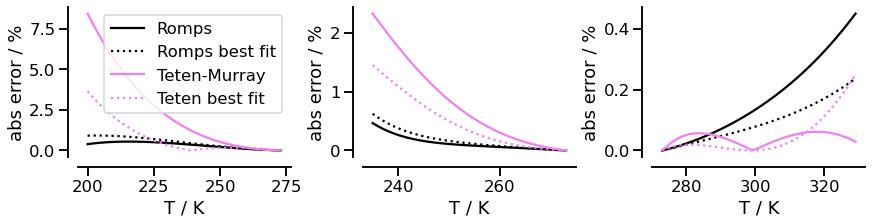

In [10]:
sns.set_context("talk")
fig, ax = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

ice_tetens_new = svp.make_tetens(
    Tref=constants.TvT, Pref=constants.PvT, a=21.875, b=7.66
)
liq_tetens_new = svp.make_tetens(
    Tref=constants.TvT, Pref=constants.PvT, a=17.269, b=35.86
)
ice_romps = svp.make_analytic(lx=constants.lsT, cx=1861.0)
liq_romps = svp.make_analytic(lx=constants.lvT, cx=4119.0)

T = np.arange(200.0, 273.16)
es_c1 = (svp.ice_analytic(T) / svp.ice_wagner_etal(T) - 1.0) * 100.0
es_c2 = (ice_romps(T) / svp.ice_wagner_etal(T) - 1.0) * 100.0
es_c3 = (ice_tetens_new(T) / svp.ice_wagner_etal(T) - 1.0) * 100.0
es_c4 = (svp.ice_tetens(T) / svp.ice_wagner_etal(T) - 1.0) * 100.0

ax[0].plot(T, np.abs(es_c1), c="k", label="Romps")
ax[0].plot(T, np.abs(es_c2), c="k", ls="dotted", label="Romps best fit")
ax[0].plot(T, np.abs(es_c3), c="violet", label="Teten-Murray")
ax[0].plot(T, np.abs(es_c4), c="violet", ls="dotted", label="Teten best fit")

T = np.arange(235.0, 273.16)
es_sc1 = (svp.liq_analytic(T) / svp.liq_murphy_koop(T) - 1.0) * 100.0
es_sc2 = (liq_romps(T) / svp.liq_murphy_koop(T) - 1.0) * 100.0
es_sc3 = (liq_tetens_new(T) / svp.liq_murphy_koop(T) - 1.0) * 100.0
es_sc4 = (svp.liq_tetens(T) / svp.liq_murphy_koop(T) - 1.0) * 100.0

ax[1].plot(T, np.abs(es_sc1), c="k")
ax[1].plot(T, np.abs(es_sc2), c="k", ls="dotted")
ax[1].plot(T, np.abs(es_sc3), c="violet")
ax[1].plot(T, np.abs(es_sc4), c="violet", ls="dotted")

T = np.arange(273.0, 330.0)
es_w1 = (svp.liq_analytic(T) / svp.liq_wagner_pruss(T) - 1.0) * 100.0


def best_romps(T):
    return (
        svp.make_analytic(lx=constants.lvT, cx=4119.0)(T) / svp.liq_wagner_pruss(T)
        - 1.0
    ) * 100


es_w2 = best_romps(T)
es_w3 = (liq_tetens_new(T) / svp.liq_wagner_pruss(T) - 1.0) * 100.0
es_w4 = ((svp.liq_tetens(T)) / svp.liq_wagner_pruss(T) - 1.0) * 100.0

ax[2].plot(T, np.abs(es_w1), c="k", label="Romps")
ax[2].plot(T, np.abs(es_w2(T)), c="k", ls="dotted", label="Romps best fit")
ax[2].plot(T, np.abs(es_w3), c="violet", label="Teten-Murray")
ax[2].plot(T, np.abs(es_w4), c="violet", ls="dotted", label="Teten best fit")

ax[0].legend()
for a in ax:
    a.set_ylabel("abs error / %")
    a.set_xlabel("T / K")

sns.despine(offset=10)

In [11]:
T = 300.0
(lambda x: svp.make_analytic(lx=constants.lsT, cx=1861.0))(T)
print((lambda x: svp.make_analytic(lx=constants.lsT, cx=1861.0))(T))
(lambda x: x + 1)(2)

<function make_analytic.<locals>.es at 0x1344b3310>


3

In [12]:
hl = mt.liquid_water_static_energy
hm = mt.moist_static_energy
T, Z, qv = 305.0, 100.0, 15.0e-3
print(hm(T=T, qv=qv, Z=Z), hl(T=T, qv=qv, Z=Z))

358347.48647272115 311350.20551272115


In [13]:
es = svp.make_tetens(Tref=constants.TvT, Pref=constants.PvT, a=22.0420, b=5.0)
es(np.asarray([273.15, 260.0]))
# array([611.21094488, 222.70984761])

array([611.15242458, 196.1007033 ])

In [16]:
import moist_thermodynamics

In [21]:
moist_thermodynamics.__version__

'0.5.0'